## Setup


In [1]:
! [[ -f data.zip ]] || wget https://www.dropbox.com/s/m1ie2zq8nkburar/data.zip?raw=1 -O data.zip && unzip data.zip

--2020-03-11 19:55:21--  https://www.dropbox.com/s/m1ie2zq8nkburar/data.zip?raw=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/m1ie2zq8nkburar/data.zip [following]
--2020-03-11 19:55:21--  https://www.dropbox.com/s/raw/m1ie2zq8nkburar/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf833c1359423e48ef611378b8f.dl.dropboxusercontent.com/cd/0/inline/AzukKFkQXrDBzMg9aR-Rrjz4Azt9SAs0wNSUhv2xdxGzbLetspbXqB24Mby44JU98JadzCJewMcQzF-PQS7tGTZdYYqHGybWIyverTzLH5WIOeXfMMykEakm73jX7Jw02E8/file# [following]
--2020-03-11 19:55:21--  https://ucf833c1359423e48ef611378b8f.dl.dropboxusercontent.com/cd/0/inline/AzukKFkQXrDBzMg9aR-Rrjz4Azt9SAs0wNSUhv2xdxGzbLetspbXqB24Mby44JU98JadzCJewMcQzF-PQS7tGTZdYYqHGybWIyverTzLH5WIOeXfMMykE

In [0]:
! [[ -d box-unet ]] || git clone --quiet https://github.com/sdll/box-conv-vis.git && mv box-conv-vis/* .

In [3]:
! pip install -q gsheet-keyring ipython-secrets comet_ml tqdm

     |████████████████████████████████| 184kB 3.8MB/s 
     |████████████████████████████████| 204kB 8.8MB/s 
     |████████████████████████████████| 409kB 11.2MB/s 
     |████████████████████████████████| 2.3MB 16.0MB/s 


In [4]:
! python3 -m pip install -q git+https://github.com/shrubb/box-convolutions.git

## Imports

In [0]:
from comet_ml import Experiment 

import argparse
from pathlib import Path

from box_convolution import BoxConv2d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm as tqdm_base
from ipython_secrets import get_secret

from pytorch_ssim import ssim

from timeit import default_timer as timer
import cv2

sns.set()


def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, "_instances"):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

## Environment

In [0]:
DATA_PATH = "data"
GROUND_TRUTH_LABEL = "ground_truth"
NOISY_IMAGES_LABEL = "noisy"
TRAIN_LABEL = "train"
TEST_LABEL = "val"
# TRAIN_POSTFIX = "normed_crops.33.tensor"
TRAIN_POSTFIX = "normalized_data.tensor"
TEST_POSTFIX = "normalized_data.tensor"
TRAIN_GT_DATA = Path(DATA_PATH) / TRAIN_LABEL / GROUND_TRUTH_LABEL / TRAIN_POSTFIX
TRAIN_NOISY_DATA = Path(DATA_PATH) / TRAIN_LABEL / NOISY_IMAGES_LABEL / TRAIN_POSTFIX
TEST_GT_DATA = Path(DATA_PATH) / TEST_LABEL / GROUND_TRUTH_LABEL / TEST_POSTFIX
TEST_NOISY_DATA = Path(DATA_PATH) / TEST_LABEL / NOISY_IMAGES_LABEL / TEST_POSTFIX

DEVICE = "cuda"

PROJECT = "fastrino"
COMET_ML_API_KEY = get_secret("comet-{}".format(PROJECT))

NUM_BOX_FILTERS = 40
MAX_INPUT_H = 1024
MAX_INPUT_W = 1024
SCALE_FACTOR = 2
BOX_VIDEO_RESOLUTION = (600, 600)
VIDEO_LOG = "box-conv-vis.avi"

In [3]:
experiment = Experiment(
    api_key=COMET_ML_API_KEY,
    project_name=PROJECT,
    workspace=PROJECT,
    auto_output_logging=None,
)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/fastrino/fastrino/363b24b5aa41478d937050c925d749a1



## Model

In [0]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   

def fit_size(template, to_fit):
    diffY = torch.tensor([template.size()[2] - to_fit.size()[2]])
    diffX = torch.tensor([template.size()[3] - to_fit.size()[3]])

    to_fit = F.pad(
        to_fit,
        [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2],
    )
    return to_fit
    
class Model(nn.Module):
    def __init__(self, in_channels, max_input_h, max_input_w):
        super().__init__()
        self.box_conv = BoxConv2d(in_channels, NUM_BOX_FILTERS, max_input_h, max_input_w)
        self.conv_1x1 = nn.Conv2d(NUM_BOX_FILTERS, NUM_BOX_FILTERS, 1)
        self.down_dconv_1 = double_conv(NUM_BOX_FILTERS, 2 * NUM_BOX_FILTERS)
        self.down_dconv_2 = double_conv(2 * NUM_BOX_FILTERS, 4 * NUM_BOX_FILTERS)
        self.down_dconv_3 = double_conv(4 * NUM_BOX_FILTERS, 8 * NUM_BOX_FILTERS)
        self.maxpool = nn.MaxPool2d(SCALE_FACTOR)
        self.upsample = nn.Upsample(scale_factor=SCALE_FACTOR, mode='nearest')   
        self.up_dconv_3 = double_conv((8 + 4) * NUM_BOX_FILTERS, 4 * NUM_BOX_FILTERS)
        self.up_dconv_2 = double_conv((4 + 2) * NUM_BOX_FILTERS, 2 * NUM_BOX_FILTERS)
        self.up_dconv_1 = double_conv((2 + 1) * NUM_BOX_FILTERS, NUM_BOX_FILTERS)
        self.last_conv = nn.Conv2d(NUM_BOX_FILTERS, in_channels, 1)

    def forward(self, x):
        original_x = x
        x = self.box_conv(x)
        x = self.conv_1x1(x)
        conv0 = nn.ReLU(inplace=True)(x)

        x = self.maxpool(x)

        conv1 = self.down_dconv_1(x)
        x = self.maxpool(conv1)

        conv2 = self.down_dconv_2(x)
        x = self.maxpool(conv2)
        
        x = self.down_dconv_3(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, fit_size(x, conv2)], dim=1)
        
        x = self.up_dconv_3(x)
        x = self.upsample(x)        
        x = torch.cat([x, fit_size(x, conv1)], dim=1)       

        x = self.up_dconv_2(x)
        x = self.upsample(x)        
        x = torch.cat([x, fit_size(x, conv0)], dim=1)   
        
        x = fit_size(original_x, x)

        x = self.up_dconv_1(x)
        out = self.last_conv(x)
        return out

## Utilities

In [0]:
def get_arg_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument("--max-input-h", type=int, default=MAX_INPUT_H)
    parser.add_argument("--max-input-w", type=int, default=MAX_INPUT_W)
    parser.add_argument("--lr", type=float, default=1e-4)
    parser.add_argument("--batch-size", type=int, default=1)
    parser.add_argument("--num-epochs", type=int, default=5)
    parser.add_argument("--seed", type=int, default=42)

    return parser


def get_criterion():
    return nn.MSELoss()


def get_optimizer(model, lr=0.001):
    return optim.Adam(model.parameters(), lr)


def psnr(prediction, target, max_pixel=255.0):
    return 10.0 * ((max_pixel ** 2) / ((prediction - target) ** 2).mean()).log10()


class PlaneLoader(torch.utils.data.Dataset):
    def __init__(self, gt_data, noisy_data):
        self.gt_data = torch.load(gt_data)
        self.noisy_data = torch.load(noisy_data)

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, index):
        noisy_image = self.noisy_data[index]
        if len(noisy_image.shape) == 2:
            noisy_image = noisy_image[None, :, :]
        gt_image = self.gt_data[index]
        if len(gt_image.shape) == 2:
            gt_image = gt_image[None, :, :]

        noise = noisy_image - gt_image
        return noisy_image, noise


def train(experiment, train_loader, log=VIDEO_LOG):
    parser = get_arg_parser()
    args = parser.parse_args(args=[])

    if VIDEO_LOG:
        box_video = cv2.VideoWriter(
            log, cv2.VideoWriter_fourcc(*"XVID"), 25, BOX_VIDEO_RESOLUTION
        )


    image, noise = next(iter(train_loader))

    args.in_channels = 1 if len(image.shape) == 3 else image.shape[1]
    experiment.log_parameters(vars(args))

    model = Model(args.in_channels, args.max_input_h, args.max_input_w).to(DEVICE)

    criterion = get_criterion()
    optimizer = get_optimizer(model, args.lr)

    for epoch in tqdm(range(args.num_epochs), desc="Epoch", unit="epochs"):
        with experiment.train():
            model.train()
            train_psnr = []
            train_ssim = []

            for image, noise in tqdm(train_loader, desc="Train images", unit="images"):
                if log:
                    video_background = torch.nn.functional.pad(
                        image[0], (14, 14, 14, 14)
                    )
                    video_background = torch.nn.functional.interpolate(
                        video_background.unsqueeze(0),
                        size=BOX_VIDEO_RESOLUTION,
                        mode="nearest",
                    )[0, 0]
                    video_background = video_background.unsqueeze(-1).repeat(1, 1, 3)
                    video_background = video_background.mul(255).round().byte().numpy()

                image = image.to(DEVICE)
                noise = noise.to(DEVICE)

                prediction = model(image)
                loss = criterion(prediction, noise)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                current_psnr = psnr(image - prediction, image - noise).data.item()
                current_ssim = ssim(image - prediction, image - noise).data.item()
                train_psnr.append(current_psnr)
                train_ssim.append(current_ssim)
                experiment.log_metric("psnr", current_psnr)
                experiment.log_metric("ssim", current_ssim)
                experiment.log_metric("loss", loss.data.item())

                if log:
                    box_importances = (
                        model.conv_1x1.weight.detach().float().abs().max(0)[0].squeeze()
                    )
                    box_importances /= box_importances.max()
                    boxes_plot = model.box_conv.draw_boxes(
                        resolution=BOX_VIDEO_RESOLUTION, weights=box_importances
                    )
                    box_video.write(
                        cv2.addWeighted(boxes_plot, 1.0, video_background, 0.25, 0.0)
                    )

            experiment.log_metric("mean_psnr", np.mean(train_psnr))
            experiment.log_metric("mean_ssim", np.mean(train_ssim))
    return model


def test(experiment, model, test_loader):
    with experiment.test():
        model.eval()
        test_psnr = []
        test_ssim = []
        test_prediction_times = []
        for image, noise in test_loader:
            image = image.to(DEVICE)
            noise = noise.to(DEVICE)
            start = timer()
            prediction = model(image)
            end = timer()
            prediction_time = end - start
            test_prediction_times.append(prediction_time)
            experiment.log_metric("prediction_time", prediction_time)
            gt_image = image - noise
            current_psnr = psnr(image - prediction, gt_image).data.item()
            current_ssim = ssim(prediction, gt_image).data.item()
            test_psnr.append(current_psnr)
            test_ssim.append(current_ssim)

        test_psnr = np.mean(test_psnr)
        test_ssim = np.mean(test_ssim)
        test_prediction_time = np.mean(test_prediction_times)

        experiment.log_metric("mean_psnr", test_psnr)
        experiment.log_metric("mean_ssim", test_ssim)
        experiment.log_metric("mean_prediction_time", test_prediction_time)

    return test_psnr, test_ssim, test_prediction_time

In [0]:
parser = get_arg_parser()
args = parser.parse_args(args=[])

train_loader = torch.utils.data.DataLoader(
    PlaneLoader(TRAIN_GT_DATA, TRAIN_NOISY_DATA),
    batch_size=args.batch_size,
    shuffle=True,
)

In [9]:
model  = train(experiment, train_loader)

Epoch: 100%|██████████| 5/5 [16:24<00:00, 196.99s/epochs]


In [0]:
del train_loader

In [0]:
test_loader = torch.utils.data.DataLoader(
    PlaneLoader(TEST_GT_DATA, TEST_NOISY_DATA), batch_size=1, shuffle=False
)

In [27]:
test_psnr, test_ssim, test_prediction_time = test(experiment, model, test_loader)
print(
    "Mean Test PSNR: {}\nMean Test SSIM: {}\nMean Prediction Time: {}".format(
        test_psnr, test_ssim, test_prediction_time
    )
)

Mean Test PSNR: 80.15872816606002
Mean Test SSIM: 0.04622456071030518
Mean Prediction Time: 0.0012944105909065745


In [0]:
test_it = iter(test_loader)

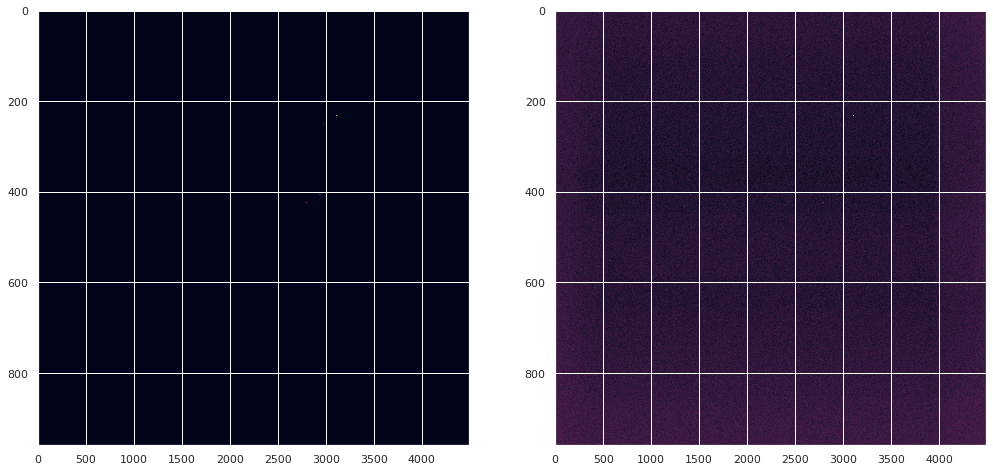

In [31]:
image, noise = next(test_it)
fig = plt.figure(figsize=(17, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow((image - noise).squeeze(), interpolation='nearest', aspect='auto')
ax2.imshow((image - model(image.to(DEVICE)).data.to("cpu")).squeeze(),
           interpolation='nearest', aspect='auto')
plt.show()

In [37]:
image.shape

torch.Size([1, 1, 960, 4492])

In [38]:
4492 / 4

1123.0

In [10]:
4488 / 32

140.25